### Preprocessing

In [1]:
import pandas as pd
df_train = pd.read_csv('../Data/training.csv')
df_test= pd.read_csv('../Data/validation.csv')
df_train.head()

,file,artist,title,year,lyrics,mood
0,TRBFHQG128F93092E5.h5,Donnie McClurkin,Psalm 27,2000,One thing have I desired up the Lord\r\r\r\r\n...,happy
1,TRAKWXS128F930F798.h5,Lollipop Lust Kill,No Answer (Outro),2002,Though I heard you say you love me\r\r\r\r\nIt...,sad
2,TRASWIV128E0788A84.h5,The Smashing Pumpkins,Real Love,2000,Fall in to the century of supersonic cross\r\r...,happy
3,TRAYTDZ128F93146E3.h5,Stevie Ray Vaughan And Double Trouble,Mary Had A Little Lamb,1988,Mary had a little lamb\r\r\r\r\nIt's fleece wa...,happy
4,TRAROPS128F92F09A5.h5,Carl Belew,Am I That Easy To Forget,1959,Am I that easy to forget?\r\r\r\r\n\r\r\r\r\nY...,sad


#### Label Encoder


In [2]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

X_train = df_train['lyrics'].values 
y_train = df_train['mood'].values

X_test = df_test['lyrics'].values 
y_test = df_test['mood'].values


print('Original: %s ...' %y_train[:5])

le_train = LabelEncoder()
le_train.fit(y_train)
y_train = le_train.transform(y_train)

le_test = LabelEncoder()
le_test.fit(y_test)
y_test=le_test.transform(y_test)

print('Encoded: %s ...' %y_train[:5])

Original: ['happy' 'sad' 'happy' 'happy' 'sad'] ...
Encoded: [0 1 0 0 1] ...


#### Reading the Stop words from English Language

In [3]:
with open('../stopwords.txt', 'r') as infile:
    stop_words = infile.read().splitlines()
print('stop words %s ...' %stop_words[:5])

stop words ['i', 'me', 'my', 'myself', 'we'] ...


### Transform texts into bag of words models - Trying different tokenizers

In [4]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import EnglishStemmer


"""
The Porter stemming algorithm (or ‘Porter stemmer’) is a process for removing the commoner morphological and inflexional 
endings from words in English. Its main use is as part of a term normalisation process that is usually done when 
setting up Information Retrieval systems.

Snowball Stemmer: https://snowballstem.org/algorithms/

"""

porter = PorterStemmer()
snowball = EnglishStemmer()

# raw words
tokenizer = lambda text: text.split()

# words after Porter stemming 
tokenizer_porter = lambda text: [porter.stem(word) for word in text.split()]

# Words after Snowball stemming
tokenizer_snowball = lambda text: [snowball.stem(word) for word in text.split()]

### Checking the vocabulary size

In [5]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


vector_1 = CountVectorizer(binary=False,
                         stop_words=stop_words,
                         ngram_range=(1,1),
                         preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()),   # [^a-zA-Z]: Anything except a..z and A..Z
                         tokenizer=tokenizer)                                                # ' ': replaced with nothing
                                                                                             # text.lower : in this string
                 
vector_2 = CountVectorizer(binary=False,
                         stop_words=stop_words,
                         ngram_range=(1,1),
                         preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()),
                         tokenizer=tokenizer_porter)
    
vector_3 = CountVectorizer(binary=False,
                         stop_words=stop_words,
                         ngram_range=(1,1),
                         preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()),
                         tokenizer=tokenizer_snowball)  

vector_4 = TfidfVectorizer(binary=False,
                         stop_words=stop_words,
                         ngram_range=(1,1),
                         preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()),
                         tokenizer=tokenizer)

vector_5 = TfidfVectorizer(binary=False,
                         stop_words=stop_words,
                         ngram_range=(1,1),
                         preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()),
                         tokenizer=tokenizer_porter)
    
vector_6 = TfidfVectorizer(binary=False,
                         stop_words=stop_words,
                         ngram_range=(1,1),
                         preprocessor=lambda text: re.sub('[^a-zA-Z]', ' ', text.lower()),
                         tokenizer=tokenizer_snowball)

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

"""

Pipelines are used to Sequentially apply a list of transforms and a final estimator. 
Intermediate steps of pipeline must implement fit and transform methods. 
Final estimator implements the fit.
"""

pipelines_BernoulliNB = []
pipelines_MultinomialNB= []

vectorizers = [vector_1, vector_2, vector_3, vector_4, vector_5, vector_6]
for v in vectorizers:
    pipelines_BernoulliNB.append(Pipeline([('vect', v),
                                ('clf', BernoulliNB())]))
    
for v in vectorizers:
    pipelines_MultinomialNB.append(Pipeline([('vect', v),
                                ('clf', MultinomialNB())]))

In [7]:
print('Vocabulary sizes\n')
labels = ['CountVec', 'CountVec porter', 'CountVec snowball','TfidfVec', 'TfidfVec porter', 'TfidfVec snowball']

for label, v in zip(labels, vectorizers):
    v.fit(X_train)
    print('%s: %s' % (label, len(v.vocabulary_)))

Vocabulary sizes

CountVec: 8188
CountVec porter: 6282
CountVec snowball: 6253
TfidfVec: 8188
TfidfVec porter: 6282
TfidfVec snowball: 6253


### Selecting Models

In [8]:
from sklearn import metrics
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

"""
The multinomial Naive Bayes classifier is suitable for classification with discrete features 
(e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. 
However, in practice, fractional counts such as tf-idf may also work.

While MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.

"""

labels = ['CountVec', 'CountVec porter', 'CountVec snowball','TfidfVec', 'TfidfVec porter', 'TfidfVec snowball']


dic_BernoulliNB = {'Data':labels,
     'ROC AUC (%)':[],}

dic_MultinomialNB = {'Data':labels,
     'ROC AUC (%)':[],}

for i,clf in enumerate(pipelines_BernoulliNB):
    scores = cross_validation.cross_val_score(estimator=clf, X=X_train, y=y_train, scoring='roc_auc', cv=10)
    print('clf %s, %s_BernoulliNB: %s' % (i+1, labels[i], scores.mean()*100))
    dic_BernoulliNB['ROC AUC (%)'].append('%0.2f (+/- %0.2f)' % (scores.mean()*100, scores.std()*100))

for i,clf in enumerate(pipelines_MultinomialNB):
    scores = cross_validation.cross_val_score(estimator=clf, X=X_train, y=y_train, scoring='roc_auc', cv=10)
    print('clf %s, %s_MultinomialNB: %s' % (i+1, labels[i], scores.mean()*100))
    dic_MultinomialNB['ROC AUC (%)'].append('%0.2f (+/- %0.2f)' % (scores.mean()*100, scores.std()*100))

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


clf 1, CountVec_BernoulliNB: 71.97374551971325
clf 2, CountVec porter_BernoulliNB: 71.70403225806452
clf 3, CountVec snowball_BernoulliNB: 71.8736559139785
clf 4, TfidfVec_BernoulliNB: 71.97374551971325
clf 5, TfidfVec porter_BernoulliNB: 71.70403225806452
clf 6, TfidfVec snowball_BernoulliNB: 71.8736559139785
clf 1, CountVec_MultinomialNB: 72.93158602150538
clf 2, CountVec porter_MultinomialNB: 72.04448924731183
clf 3, CountVec snowball_MultinomialNB: 72.47795698924732
clf 4, TfidfVec_MultinomialNB: 74.06021505376344
clf 5, TfidfVec porter_MultinomialNB: 74.54883512544802
clf 6, TfidfVec snowball_MultinomialNB: 74.6478494623656


### Plotting ROC Curve with Hyper parameter tuning

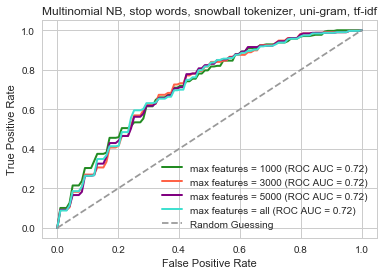

In [9]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

"""
StratifiedKFold: This cross-validation object is a variation of KFold that returns stratified folds. 
The folds are made by preserving the percentage of samples for each class.
"""


sns.set()
sns.set_style("whitegrid")

forestGreen= '#228B22'
tomato= '#FF6347'
turqouise='#40E0D0'
purple = '#800080'

colors = [forestGreen, tomato, purple, turqouise]
maxFeatures = [1000,3000,5000,None]
labels = ['max features = 1000', 
          'max features = 3000',
          'max features = 5000',
          'max features = all',
          ]

for maxFeat,col,lab in zip(maxFeatures, colors, labels):

    classifier = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=tokenizer_porter,
                                                  ngram_range=(1,1),
                                                  max_features=maxFeat,
                                                  )
                          ),
                         ('clf', MultinomialNB()),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    crossValidation = StratifiedKFold(y_train, n_folds=10, random_state=1)

    for i, (train, test) in enumerate(crossValidation):
        probas_ = classifier.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(crossValidation)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial NB, stop words, snowball tokenizer, uni-gram, tf-idf')
plt.legend(loc="lower right")
plt.savefig('../Images/roc_multinomialNB_maxfeatures.png', dpi=600)
plt.show()


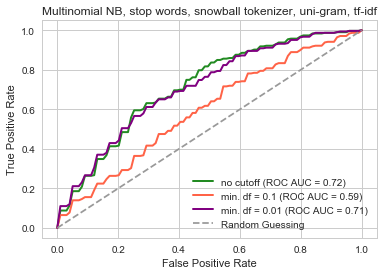

In [10]:
"""  min_df: min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
     min_df = 5 means "ignore terms that appear in less than 5 documents".

"""

sns.set()
sns.set_style("whitegrid")

forestGreen= '#228B22'
tomato= '#FF6347'
turqouise='#40E0D0'
purple = '#800080'

colors = [forestGreen, tomato, purple, turqouise]
minDF = [1, 0.1, 0.01]
labels = ['no cutoff',
          'min. df = 0.1', 
          'min. df = 0.01',
          ]


for minDF,col,lab in zip(minDF, colors, labels):

    classifier = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=tokenizer_porter,
                                                  ngram_range=(1,1),
                                                  min_df=minDF,
                                                  )
                          ),
                         ('clf', MultinomialNB()),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    crossValidation = StratifiedKFold(y_train, n_folds=10, random_state=1)

    for i, (train, test) in enumerate(crossValidation):
        probas_ = classifier.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(crossValidation)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial NB, stop words, snowball tokenizer, uni-gram, tf-idf')
plt.legend(loc="lower right")
plt.savefig('../Images/roc_multinomialNB_minDF.png', dpi=600)
plt.show()

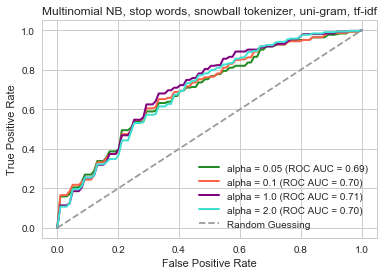

In [11]:
"""  
Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

"""

sns.set()
sns.set_style("whitegrid")

forestGreen= '#228B22'
tomato= '#FF6347'
turqouise='#40E0D0'
purple = '#800080'

colors = [forestGreen, tomato, purple, turqouise]
alphas = [0.05, 0.1, 1.0, 2.0]
labels = ['alpha = 0.05', 
          'alpha = 0.1',
          'alpha = 1.0',
          'alpha = 2.0',
          ]


for alpha,col,lab in zip(alphas, colors, labels):

    classifier = Pipeline([
                         ('vect', TfidfVectorizer(
                                                  binary=False,
                                                  stop_words=stop_words,
                                                  tokenizer=tokenizer_snowball,
                                                  ngram_range=(1,1),
                                                  )
                          ),
                         ('clf', MultinomialNB(alpha=alpha)),
                        ])
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    crossValidation = StratifiedKFold(y_train, n_folds=10, random_state=1)

    for i, (train, test) in enumerate(crossValidation):
        probas_ = classifier.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(crossValidation)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multinomial NB, stop words, snowball tokenizer, uni-gram, tf-idf')
plt.legend(loc="lower right")
plt.savefig('../Images/roc_multinomialNB_alpha.png', dpi=600)
plt.show()

### Validating Model

In [12]:
val_CF = Pipeline([
                ('vect', TfidfVectorizer(
                                         binary=False,
                                         stop_words=stop_words,
                                         tokenizer=tokenizer_snowball,
                                         ngram_range=(1,1),
                                         )
                ),
                ('clf', MultinomialNB(alpha=1.0)),
               ])
val_CF.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

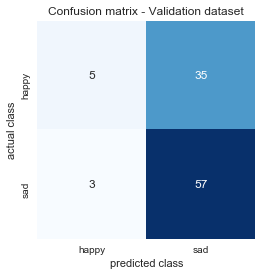

In [13]:
import matplotlib as mpl

y_valid=y_test
X_valid=X_test
confusionMatrix = metrics.confusion_matrix(y_valid, val_CF.predict(X_valid))

#np.set_printoptions(suppress=True)
#mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(confusionMatrix, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Validation dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('../Images/confmat_validation.png', dpi=600)
plt.show()


In [14]:
from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

acc_scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
pre_scorer = metrics.make_scorer(metrics.precision_score, greater_is_better=True, pos_label=0)
rec_scorer = metrics.make_scorer(metrics.recall_score, greater_is_better=True, pos_label=0)
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)

In [15]:
labels = ['Training', 'Validation']

dic = {'Data':labels,
     'ACCURACY (%)':[],
     'PRECISION (%)':[],
     'RECALL (%)':[],
     'F1 (%)':[],
     'ROC AUC (%)':[],
}


dic['ACCURACY (%)'].append(acc_scorer(estimator=val_CF, X=X_train, y_true=y_train))
dic['PRECISION (%)'].append(pre_scorer(estimator=val_CF, X=X_train, y_true=y_train))
dic['RECALL (%)'].append(rec_scorer(estimator=val_CF, X=X_train, y_true=y_train))
dic['F1 (%)'].append(f1_scorer(estimator=val_CF, X=X_train, y_true=y_train))
dic['ROC AUC (%)'].append(auc_scorer(estimator=val_CF, X=X_train, y_true=y_train))

dic['ACCURACY (%)'].append(acc_scorer(estimator=val_CF, X=X_valid, y_true=y_valid))
dic['PRECISION (%)'].append(pre_scorer(estimator=val_CF, X=X_valid, y_true=y_valid))
dic['RECALL (%)'].append(rec_scorer(estimator=val_CF, X=X_valid, y_true=y_valid))
dic['F1 (%)'].append(f1_scorer(estimator=val_CF, X=X_valid, y_true=y_valid))
dic['ROC AUC (%)'].append(auc_scorer(estimator=val_CF, X=X_valid, y_true=y_valid))

In [16]:
performance = pd.DataFrame(dic)
performance = performance[['ACCURACY (%)', 'PRECISION (%)', 'RECALL (%)', 'F1 (%)', 'ROC AUC (%)']]
performance.index=(labels)
performance = performance*100
performance = np.round(performance, decimals=2)
performance

,ACCURACY (%),PRECISION (%),RECALL (%),F1 (%),ROC AUC (%)
Training,86.55,100.0,69.55,82.04,84.77
Validation,62.00,62.5,12.50,20.83,53.75


In [18]:
performance.to_csv('../Data/MultinomialNM_performance.csv', index_label=False, float_format='%2.2f')